In [62]:
import os
from tempfile import gettempdir
from dataclasses import dataclass

import numpy as np
import onnxruntime as ort
from PIL import Image as PILImage
import mlflow
from mlflow.tracking import MlflowClient
from dotenv import load_dotenv
import cv2
import matplotlib.pyplot as plt


In [96]:
load_dotenv()

True

In [97]:
MLFLOW_URI = os.getenv("MLFLOW_URI", "http://host.docker.internal:8080")
EVAL_VIDEOS_DIR = os.getenv("EVAL_VIDEOS_DIR")
MLFLOW_MODEL_NAME = "frame_classifier_224x224"
MLFLOW_MODEL_ALIAS = "champion"
TARGET_IMAGE_HEIGHT = 224
TARGET_IMAGE_WIDTH = 224

In [103]:
VIDEO_PATHS = os.listdir(EVAL_VIDEOS_DIR)

In [8]:
mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_registry_uri(MLFLOW_URI)
mlflow_client = MlflowClient(tracking_uri=MLFLOW_URI, registry_uri=MLFLOW_URI)

In [11]:
temp_dir = gettempdir()

In [22]:
model_version_info = mlflow_client.get_model_version_by_alias(name=MLFLOW_MODEL_NAME, alias=MLFLOW_MODEL_ALIAS)
run_id = model_version_info.run_id
model_version = model_version_info.version
model_file_name = model_version_info.source.split("/")[-1]
mlflow.artifacts.download_artifacts(run_id=run_id, dst_path=temp_dir)
MODEL = ort.InferenceSession(f"{temp_dir}/{model_file_name}")
os.remove(f"{temp_dir}/{model_file_name}")

In [23]:
def predict(data: np.ndarray) -> np.ndarray:
    """Make predictions using the loaded model"""
    return MODEL.run(None, {"input": data})

In [95]:
@dataclass
class Run():
    start: int
    max_prob: float
    max_index: int
    length: int

@dataclass
class VideoPrediction():
    frames: np.ndarray
    probabilities: np.ndarray
    runs: list[Run]


In [108]:
def resize_and_normalize_image(
    image: cv2.typing.MatLike,
    target_height: int=TARGET_IMAGE_HEIGHT,
    target_width: int=TARGET_IMAGE_WIDTH
) -> np.ndarray[np.float32]:
    """Resize and normalize an image to the target height and width"""
    bw_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    pil_image = PILImage.fromarray(bw_image)
    pil_image = pil_image.resize((target_width, target_height), PILImage.LANCZOS)
    return (np.array(pil_image).astype(np.float32) / 255.0 - 0.5) / 0.5  

In [107]:
def get_video_frames(video_path: str) -> list[cv2.typing.MatLike]:
    """Extract frames from a video file"""
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

In [109]:
def get_runs(
    predictions: np.ndarray,
    run_threshold: float,
    min_run_length: int,
    patience: int
) -> list[Run]:
    """Get runs of predictions above a certain threshold"""
    runs: list[Run] = []
    run_start = None
    patience_counter = 0
    for i, prob in enumerate(predictions):
        if prob >= run_threshold:
            if run_start is None:
                run_start = i
        elif run_start is not None:
            patience_counter += 1
        if patience_counter > patience:
            run_end = i - patience_counter
            run_length = run_end - run_start + 1
            if run_length >= min_run_length:
                max_index = np.argmax(predictions[run_start:run_end + 1]) + run_start
                max_prob = predictions[max_index]
                runs.append(Run(start=run_start, max_prob=max_prob, max_index=max_index, length=run_length))
            run_start = None
            patience_counter = 0
    return runs

In [110]:
def process_video(video_path: str) -> VideoPrediction:
    """Process a video file and return the frames, probabilities, and runs"""
    frames = get_video_frames(video_path)
    processed_frames = np.array([resize_and_normalize_image(frame) for frame in frames], dtype=np.float32)
    processed_frames = processed_frames[:, np.newaxis, :, :]
    predictions = predict(processed_frames)[0]
    runs = get_runs(predictions, run_threshold=0.9, min_run_length=5, patience=2)
    return VideoPrediction(frames=np.array(frames), probabilities=predictions, runs=runs)

In [114]:
RUN_THRESHOLD = 0.8
MIN_RUN_LENGTH = 5
PREDICTION_THRESHOLD = 0.95
PATIENCE = 2

In [115]:
video_preds: list[VideoPrediction] = [process_video(os.path.join(EVAL_VIDEOS_DIR, video_path)) for video_path in VIDEO_PATHS]

In [112]:
def plot_prediction(
    video_pred: VideoPrediction,
    ax: plt.Axes,
):
    """Plot the predictions for a video"""
    ax.plot(video_pred.probabilities, label="Prediction Probability", color="blue")
    for run in video_pred.runs:
        ax.plot(np.arange(run.start, run.start + run.length),
                video_pred.probabilities[run.start:run.start + run.length],
                label=f"Run {run.start}-{run.start + run.length - 1}",
                color="red" if run.max_prob >= PREDICTION_THRESHOLD else "orange")
        if run.max_prob >= PREDICTION_THRESHOLD:
            ax.annotate(f"Max Prob: {run.max_prob[0]:.2f}\nFrame: {run.max_index}",
                        xy=(run.max_index, run.max_prob),
                        xytext=(run.max_index, run.max_prob + 0.1),
                        arrowprops=dict(facecolor='black', arrowstyle='->'),
                        fontsize=8,
                        ha='center')
    ax.grid(True)
    ax.set_ylabel("Probability")
    ax.set_ylim(0, 1)
    ax.set_xlabel("Frame Index")

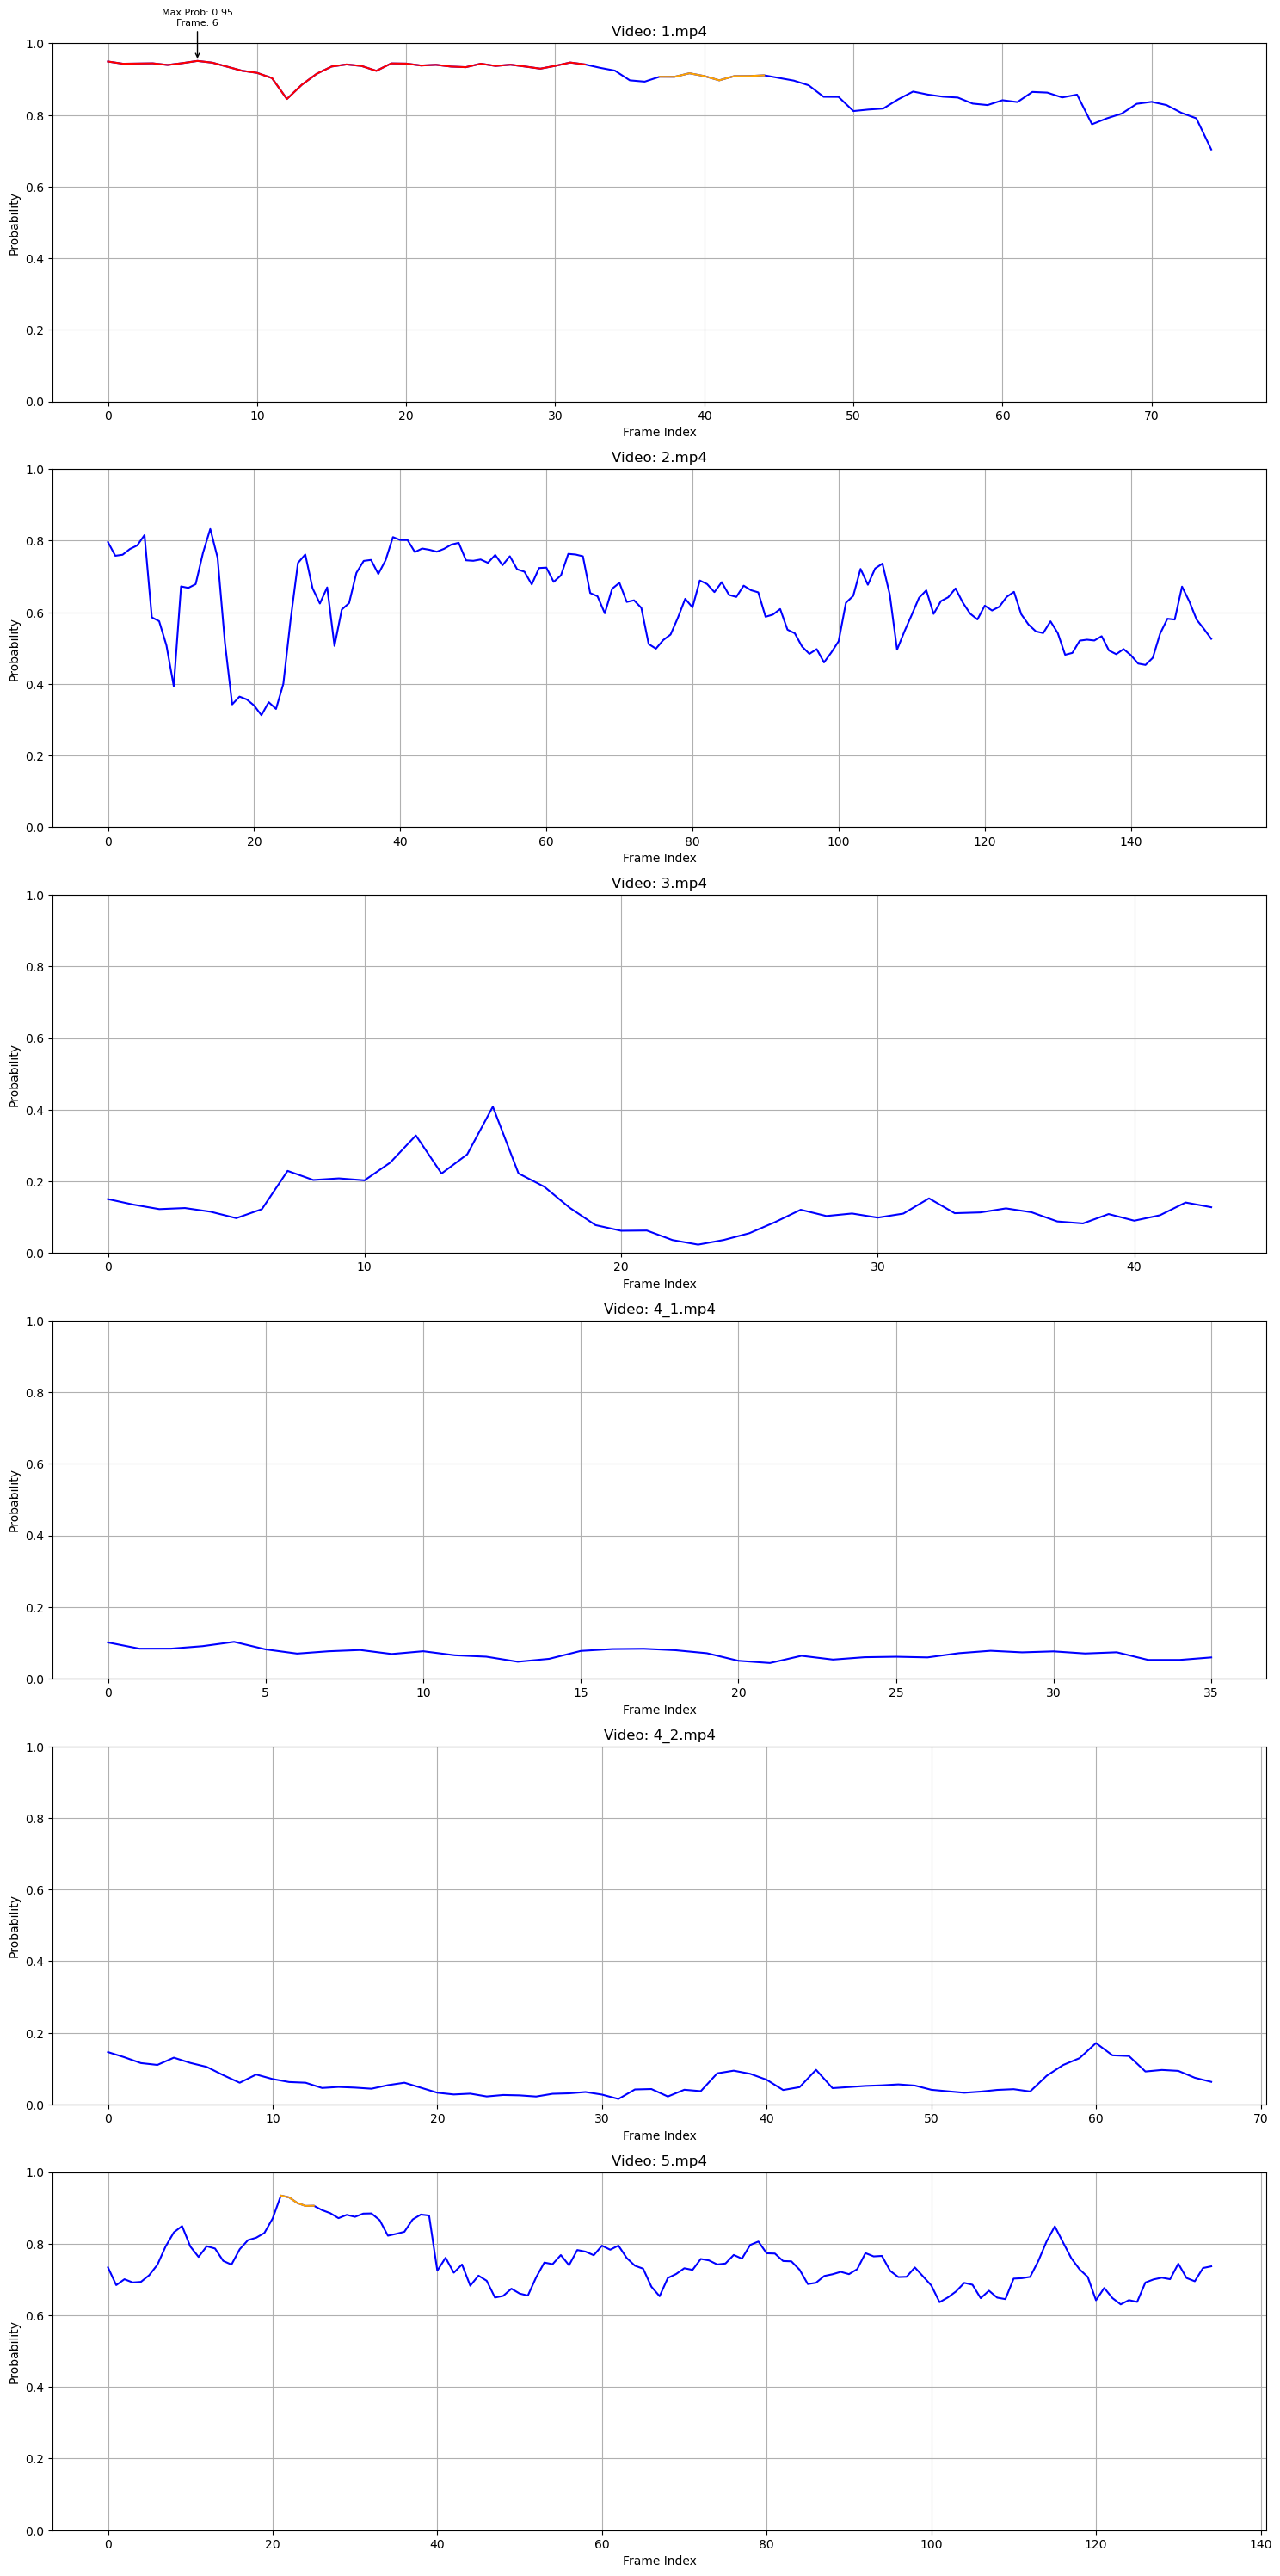

In [116]:
fig, axs = plt.subplots(len(video_preds), 1, figsize=(15, 5 * len(video_preds)), num="Video Predictions")
if len(video_preds) == 1:
    axs = [axs]
for file_name, video_pred, ax in zip(VIDEO_PATHS, video_preds, axs):
    ax.set_title(f"Video: {file_name}")
    plot_prediction(video_pred, ax)
fig.tight_layout()
plt.show()
    
    